# **CS 450 Final Exam**

**BYU CS 450 Fall 2020**

**Instructor: Ryan Farrell**

---

## Exam Instructions

<span style='color:red'>Please READ carefully and FOLLOW all instructions in this exam.</span>

This exam consists of three coding exercises. The exercises are intended to give you the opportunity to implement a few things that we talked about during the second half of the course, but never explicitly coded. Each problem has supporting instructions and code, and is broken down into several parts. The problems were not designed to be overly challenging, but don't stress out if you have trouble with them. Partial credit will be given generously if you make a valiant attempt and explain your struggles.

The exam is meant to be completed in a single sitting -- but you are allowed to work on it any time during the exam period. PLEASE keep track of each block of time you spend working on it (there's a place to record this immediately below these instructions).

The exam period will open <span style='color:red'>SATURDAY, DECEMBER 12 at 7:00AM</span>. The exam period will close <span style='color:red'>THURSDAY, DECEMBER 17 at 9:00PM</span>. This gives you our assigned final exam time block to work on it (December 14 from 7AM to 10PM), as well as several days before/after if you need them.  It is intended to take you approximately 3 hours, but there is not a time limit.

<span style='color:red'>YOU MUST SUBMIT YOUR EXAM TO LEARNING SUITE BY 9:00PM ON THURSDAY  (DECEMBER 17)</span>, unless another arrangement has been made with me beforehand. If you forsee a problem, talk to me BEFORE the deadline -- preferably a day or more before -- and we can talk about other options.

**PLEASE NOTE the following**:

- The exam is to be completed individually. You SHOULD NOT discuss the exam or solutions with other students during the examination period.
- The exam is OPEN MATERIALS: you MAY use the course website and slides, previous labs, and resources published on the internet. You MAY NOT use the work of other students in the class, or ask NEW questions on online forums like Stack Overflow, Reddit, or Quora (browsing old questions and answers is fine).
- DO NOT copy-paste code from other sources.  Instead understand how it works and then code the same ideas on you own.
- If you adapt existing code or base it on code/ideas you found elsewhere, please make a note of the source you used.
- You MAY seek help and clarification from the instructor (Dr. Farrell), who will do his best to assist you should you need it.
- You can get 30% on this exam just by submitting it on time to learning suite.

Each problem requires you to fill in code for one or more functions, and possibly a short write up. In addition, you may need to run setup and test code. Each of these is marked with a corresponding tag for clarity:<br> <span style="color:green">**[SETUP]**</span> <span style="color:green">**[CODE]**</span> <span style="color:green">**[TEST]**</span> or <span style="color:green">**[WRITE]**</span>

The point totals for each problem are also shown in green, i.e. <span style="color:green">[15 pts]</span>

## Time

<span style="color:red">Please record the start and end time for each block of time that you spend on the exam.</span>


Start: 12/12 at 3pm

End: 12/12 at 4pm

Start: 12/15 at 8am

End: 12/15 at 10am

Start: 12/16 at 7am

End: 12/16 at 9am

## Problems

1. **The Integral Image**
  1. **<span style='color:green'>[20 pts]</span>** Fast Region Statistics
  1. **<span style='color:green'>[10 pts]</span>** Rectangle Features (<span style='color:green'>5 pts</span> extra credit available)
1. **<span style='color:green'>[10 pts]</span> Support Vector Machines**
1. **<span style='color:green'>[30 pts]</span> Eigenfaces**
1. **<span style='color:green'>[5 pts]</span> Final Thoughts**
1. **<span style='color:green'>[30 pts]</span> Submit this Notebook on LearningSuite**

There are a total of 110 points available. 100 points is 100%, so you can get up to 10% extra credit.

## Notebook Setup

<span style="color:green;font-size:18px;">**[SETUP]**</span> **Run this code to set up the needed libraries.**

In [167]:
%pylab inline
from IPython.display import HTML

import requests
from io import BytesIO
from PIL import Image
from pathlib import Path
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


/mnt/c/Users/orion/Desktop/Fall 2020/CS450/env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


---
## **Problem 1: The Integral Image**
---

### Part A: Fast Region Statistics

#### Background

For your latest computer vision application, you need to be able to very quickly compute the local mean and standard deviation of pixel values in an arbitrary neighborhood of an image. It needs to be fast, because you have to do it many times on the image at multiples scales. You know that `numpy` has `mean()` and `std()` functions that can compute these values, so you quickly code something up and do some timing tests:

<span style="color:green;font-size:18px;">**[SETUP]**</span> **Run these cells.**

In [168]:
grayimg = imread('baby-yoda.jpg').mean(2)

In [169]:
def get_stats(img, y, x, h, w):
    '''Get the local mean and standard deviation of an image neighborhood.
    (y, x) is the upper left corner of the neighborhood; h and w are the
    width and height of the neighborhood.'''
    m = img[y:y+h, x:x+w].mean()
    s = img[y:y+h, x:x+w].std()
    return m, s

In [170]:
def test_get_stats(img, size):
    '''Sample a random location in the image and compute the stats in a
    neighborhood of a given size.'''
    y = np.random.randint(0, img.shape[0]-size)
    x = np.random.randint(0, img.shape[1]-size)
    return get_stats(img, y, x, size, size)

for s in [50, 150, 300]:
    %timeit -n2500 -r5 test_get_stats(grayimg, s)

60.2 µs ± 9.19 µs per loop (mean ± std. dev. of 5 runs, 2500 loops each)
170 µs ± 20.9 µs per loop (mean ± std. dev. of 5 runs, 2500 loops each)
380 µs ± 61.2 µs per loop (mean ± std. dev. of 5 runs, 2500 loops each)


After running the tests, you realize that this approach is not going to work. Larger regions take far too long to calculate, and even the smaller ones aren't as fast as you were hoping for. You're about to despair, but then you remember a technique called the **Integral Image** that can help speed up computation involving sums of pixels in rectangular image regions: exactly what you need! You decide to implement your statistics calculator using integral images and see if it gives you the boost in performance you need.

#### **SOLUTION**

- <span style='color:green'>**[12 pts]**</span> Fill in the code for the `create_integral_images` function. This should return to integral images: one for the pixels and one for the pixels squared
- <span style='color:green'>**[8 pts]**</span> Fill in the code for the `stats_from_ii` function. This should return the mean and standard deviation of the specified region.
- Run the test code to show that your method computes the correct values, and to show the speed difference compared to the numpy `mean` and `std` methods.

#### *Some Useful Information*

**Statistics** 

Recall the definition of the sample mean, or expected value
$$\mu_x=E[\mathbf{x}]=\frac{1}{n}\sum_{i=1}^{n}x_i$$
which is just the average value in $\mathbf{x}$.

Similarly, for the standard deviation we have
$$\sigma_x=\sqrt{E[(\mathbf{x}-\mu_x)^2]}=\sqrt{\frac{1}{n}\sum_{i=1}^{n}(x_i-\mu_x)^2}$$
which is the average difference from the mean. 

The following identity is quite useful:
$$E[(\mathbf{x}-\mu_x)^2]=E[\mathbf{x}^2]-\mu_x^2$$
Use this to calculate the standard deviation, since it decouples the computation into two parts, each of which can be computed from a different integral image (the integral image of the pixels and the integral image of the squared pixels).

**Integral Image**

Remember to pad the integral image with a row of zeros at the top and a column of zeros on the left, so that you can correctly calculate the sum in regions that include the left or top edge of the image.

<span style="color:green;font-size:18px;">**[SETUP]**</span> **Run these cells.**

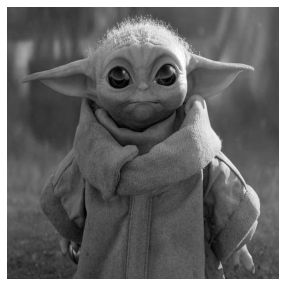

In [171]:
figure(figsize=(5,5));imshow(grayimg,cmap='gray');gca().axis('off');pass

In [172]:
# ---- testing functions -----
def validate_stats(img, ii, iis):
    '''Returns True if stats from integral image method matches stats from
    numpy method.'''
    size = np.random.randint(50, min(img.shape[:2]))
    y = np.random.randint(0, grayimg.shape[0]-size)
    x = np.random.randint(0, grayimg.shape[1]-size)
    np_stats = get_stats(img, y, x, size, size)
    ii_stats = stats_from_ii(ii, iis, y, x, size, size)
    return np.allclose(np_stats, ii_stats)

def test_ii_stats(ii, iis, size):
    y = np.random.randint(0, grayimg.shape[0]-size)
    x = np.random.randint(0, grayimg.shape[1]-size)
    return stats_from_ii(ii, iis, y, x, size, size)
# -----------------------------

<span style='color:green;font-size:18px'>**[CODE]**</span> **Fill in the two functions below.**

In [173]:
# WRITE THE CODE FOR THESE TWO FUNCTIONS

def create_integral_images(img):
    '''Given an image, creates the integral images of the image pixels (ii)
    and the image pixels squared (iis).'''
    img_sq = np.square(img)
    ii = np.zeros((img.shape[0]+1, img.shape[1]+1))
    iis = np.zeros((img.shape[0]+1, img.shape[1]+1))
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            ii[row+1, col+1] = img[row, col] + ii[row+1, col] + ii[row, col+1] - ii[row, col]
            iis[row+1, col+1] = img_sq[row, col] + iis[row+1, col] + iis[row, col+1] - iis[row, col]
    return ii, iis

def stats_from_ii(ii, iis, y, x, h, w):
    '''Calculates the mean and standard deviation of an image neighborhood.
    The image is represented as two integral images -- ii and iis -- which
    contain the integral image of the pixels and the integral images of the
    squared pixels, respectively. (y, x) is the upper left corner of the
    neighborhood; h and w are the width and height of the neighborhood.'''
    n = h * w
    mean = (ii[y, x] + ii[y + h, x + w] - ii[y + h, x] - ii[y, x + w]) / n
    if iis is not None:
        mean_squared = (iis[y, x] + iis[y + h, x + w] - iis[y + h, x] - iis[y, x + w]) / n
        std = np.sqrt(mean_squared - np.square(mean))
        return mean, std
    return mean

In [174]:
# test_array = np.array([[1, 2, 3], [2, 3, 4]])
# print(f"Test Array is \n{test_array}\nResults are:")
# print(np.square(test_array))
# ii, iis = create_integral_images(test_array)
# print(iis)
# print("\nMy stats are", stats_from_ii(ii, iis, 0, 0, 2, 3))
# print("Their stats are:", get_stats(test_array, 0, 0, 2, 3))
# test_array.mean()

<span style='color:green;font-size:18px'>**[TEST]**</span> **Run the test code in the next two cells.**

In [175]:
ii, iis = create_integral_images(grayimg)

same_stats = all([validate_stats(grayimg, ii, iis) for _ in range(100)])
color = 'green' if same_stats else 'red'
s = 'PASSED' if same_stats else 'FAILED'
display(HTML('Same stats test <span style="color:{}">{}</span>'.format(color,s)))

In [194]:
for s in [50, 150, 300]:
    %timeit -n5000 -r7 test_ii_stats(ii, iis, s)

15.2 µs ± 4.71 µs per loop (mean ± std. dev. of 7 runs, 5000 loops each)
13.5 µs ± 3.81 µs per loop (mean ± std. dev. of 7 runs, 5000 loops each)
14.6 µs ± 2.69 µs per loop (mean ± std. dev. of 7 runs, 5000 loops each)


### Part B: Rectangle Features

#### Background

You've been tasked with building a system that can automatically detect Baby Yoda's eyes in an image. Your detector needs to be simple and fast. You remember that the Viola-Jones detection algorithm uses rectangular features, which can be calculated very quickly using an integral image. Furthermore, you realize that Baby Yoda has large dark eyes which stand out against the lighter bridge of his nose. This makes you think that a rectangular feature detector that looks for a "dark-light-dark" pattern might work. You decide to try it out.

#### **SOLUTION**

- <span style='color:green'>**[8 pts]**</span> Fill in the code for the `evaluate_feature` function. Use the integral image you calculated previously to apply the rectangle feature (shown below) at each location in the image, generating a response map. Use a region size of 40x40 pixels for each of the "boxes" in the feature.
- <span style='color:green'>**[2 pts]**</span> Answer the writing prompt.
- <span style='color:green'>**[5 pts]**</span> EXTRA CREDIT will be given for a fully vectorized solution.
- Run the test code to display the response map.

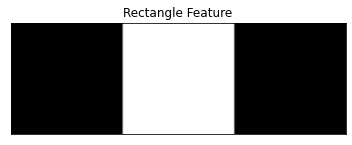

In [177]:
feature = np.zeros((40,120))
feature[:, 40:80] = 1
imshow(feature,cmap='gray');xticks([]);yticks([]);title('Rectangle Feature');pass

#### *Some Useful Information*

**Every Location**

You need to evaluate the feature at every location. What this really means is at every possible position where the feature is in-bounds of the image. Since the feature is 40 pixels high and 120 pixels wide, this means that the response map will be 40 pixels smaller vertically and 120 pixels smaller horizontally than the input image. The test code pads the response map so that each response lines up with the pixel at the center of the region which was used to calculate it.

<span style='color:green;font-size:18px'>**[CODE]**</span> **Fill in the function below.**

In [178]:
# WRITE THE CODE FOR THIS FUNCTION

def evaluate_feature(ii):
    '''Use an integral image (ii) to calculate a rectangular feature response at
    each position in an image. Make sure to remove the first row and column (the
    padding).'''
    size = 40
    h = size
    w = size
    rows, cols = ii.shape[0] - 1, ii.shape[1] - 1
    response = np.zeros((rows - 40, cols - 120))
    for y in range(rows-40):
        for x in range(cols-120):
            # +1 to each x and y to remove the padding (ii at zeros is padding)
            dark_1 = -1 * stats_from_ii(ii, None, y+1, x+1, h, w) * (h * w)
            light = stats_from_ii(ii, None, y+1, x+41, h, w) * (h * w)
            dark_2 = -1 * stats_from_ii(ii, None, y+1, x+81, h, w) * (h * w)
            response[y, x] = dark_1 + light + dark_2
            
    return response

<span style='color:green;font-size:18px'>**[TEST]**</span> **Run the test code in the cell below.**

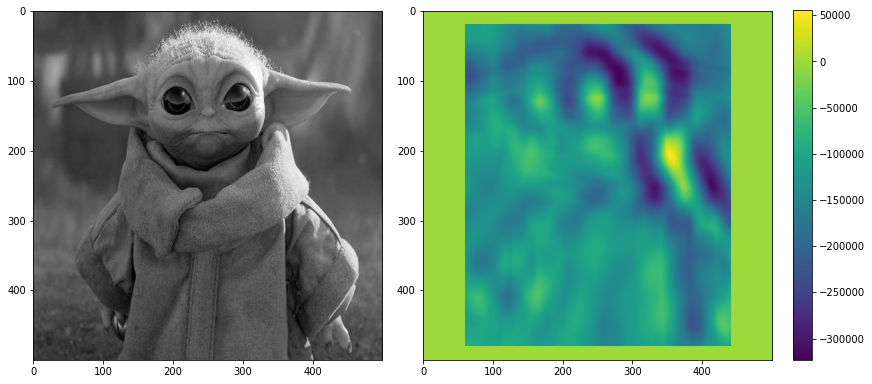

In [179]:
v = evaluate_feature(ii)
v = np.pad(v, ((20,20),(60,60)))
fig, ax = subplots(1, 2, figsize=(12,6), constrained_layout=True)
ax[0].imshow(grayimg, cmap='gray')
ax[1].imshow(v)
fig.colorbar(ax[1].images[0], ax=ax, fraction=0.05, aspect=30, shrink=.81)

<span style='color:green;font-size:18px'>**[WRITE]**</span> **In the cell below, provide a brief answer these questions: How well does this feature work? Is it enough by itself to detect Baby Yoda's eyes? Why or why not?**

It does highlight the eyes, but also highlights a lot of other areas.  So by itself, its not enough to detect Baby Yoda's eyes.  You would probably need some combination of features or some other tool to isolate the eyes only and remove all the other spurious sections.

---

## **Problem 2: Support Vector Machines**

---

### Part A: Find the Maximum-margin Line

#### Background

You're tasked with finding the maximum-margin line separating two sets of points in two dimensions. While the prospect may seem daunting, do not despair -- the support vectors are provided to you, and you don't need to work out any solutions by hand. For this task, we won't be doing anything fancy -- just finding the line that is equidistant from the two sets of support vectors.

Recall that the support vectors $\mathbf{x}_i$ satisfy the following equation with respect to the maximum-margin hyperplane (line) defined by the parameters $\mathbf{w}$:
$$\mathbf{x}_i\cdot \mathbf{w}+b=\pm 1$$
where the plus-or-minus 1 depends on which class the support vector belongs to. In two dimensions, this is just the equation
$$m_1x_i+m_2y_i+b=\pm1$$
which is a slightly rearanged formula for a line:
$$y=-\frac{m_1}{m_2}x-\frac{b\pm1}{m_2}$$

We have several support vectors and we need to solve for the parameters $m_1,m_2,b$. We can do this by solving a linear system of equations. Lets assume we have four support vectors, where the first two are positive examples and the second two are negative. Then we need to solve
$$
\begin{bmatrix}x_1 & y_1 & 1 \\ x_2 & y_2 & 1 \\ x_3 & y_3 & 1 \\ x_4 & y_4 & 1\end{bmatrix}
\begin{bmatrix}m_1 \\ m_2 \\ b\end{bmatrix} = \begin{bmatrix}1\\1\\-1\\-1\end{bmatrix}$$
which we can do by least squares -- use `np.linalg.lstsq` or `np.linalg.pinv`.

Once we have the parameters $m_1,m_2$ and $b$, we can get the slope and intercept of the maximum-margin line: $\bar{m}=-\frac{m_1}{m_2}$ and $\bar{b}=-\frac{b}{m_2}$.

*Note: This isn't actually how support vector machines find the line -- they solve an optimization problem that simultaneously determines the support vectors and corresponding weights, and which incorporates regularization. But this is a simple way that we can do something similar.*

#### **SOLUTION**

- <span style='color:green'>**[10 pts]**</span> Fill in the code for the `max_margin_slope_intercept` function. It should return both the slope and intercept, as derived from the support vectors.
- Run the test code to show the data and the max-margin line.

<span style="color:green;font-size:18px;">**[SETUP]**</span> **Run the following cell.**

In [180]:
g1 = (array([3.5, -1.5]), array([[2, 1.1], [1.1, 1.5]]))
g2 = (array([1, 2]), array([[.5, .5],[.5, 1.2]]))
npoints = 80

# Setting the random state insures that we all get the same data every time
R = np.random.RandomState(0)
d1 = R.multivariate_normal(*g1, (npoints,))
d2 = R.multivariate_normal(*g2, (npoints,))

# from sklearn.svm import LinearSVC
# data = concatenate((d1,d2),0)
# labels = concatenate((np.ones(npoints), np.zeros(npoints)))
# svm = LinearSVC(C=50).fit(data, labels)
# sv_ind = np.where((2*labels-1) * svm.decision_function(data) <= 1)[0]

data = concatenate((d1,d2),0)
support_vs = data[[1,21,118,146]]
support_lab = array([1,1,-1,-1])

print(support_vs, support_lab)

[[ 1.09981506 -1.15466411]
 [ 4.80253548  1.5082021 ]
 [ 1.06482681 -0.06987268]
 [ 0.17454566 -0.70913191]] [ 1  1 -1 -1]


<span style="color:green;font-size:18px;">**[CODE]**</span> **Fill in the function below.**

In [181]:
# WRITE THE CODE FOR THIS FUNCTION

def max_margin_slope_intercept(svs, labels):
    '''Computes the slope and intercept of the line which provides the
    maximum margin between the two classes of data. svs are the support
    vectors, and labels are the corresponding class labels.'''
    new_svs = [np.append(item, [1]) for item in svs]
    matrix = np.array(new_svs)
#     print(matrix, labels)
    values = np.linalg.lstsq(matrix, labels, rcond=None)[0]
#     print(values)
    m = -1 * (values[0] / values[1])
    b = -1 * (values[2] / values[1])
    return m, b

<span style="color:green;font-size:18px;">**[TEST]**</span> **Run the following cell.**

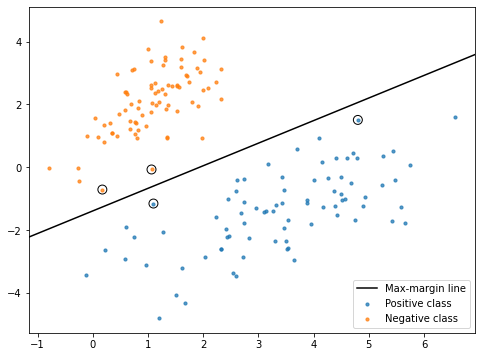

In [182]:
figure(figsize=(8,6))
scatter(*d1.T, marker='.', s=40, alpha=.75, label='Positive class')
scatter(*d2.T, marker='.', s=40, alpha=.75, label='Negative class')
scatter(*support_vs.T, color='k', s=80,
        linewidth=1, facecolors='none', edgecolors='k')

m, b = max_margin_slope_intercept(support_vs, support_lab)
xx = np.array(gca().get_xlim())
yy = m*xx + b
plot(xx, yy, c='k', label='Max-margin line')
xlim(xx)
legend(loc='lower right')
pass

---
## **Problem 3: Eigenfaces**
---

#### Background

Eigenfaces is a method for facial recognition (classification). It uses PCA to find a set of basis vectors -- the "eigenfaces" -- that describe a subspace that represents well the training face images. In this problem, you will implement Eigenfaces -- and you'll realize there's not much to it! (Especially when you don't have to implement the PCA part yourself).

#### **SOLUTION**

- <span style='color:green'>[7 pts]</span> Fill in the code for functions `split_train_test` and `fit_pca`.
- <span style='color:green'>[5 pts]</span> Display the average face in one image and the first 100 eigenfaces in another. Use the `toimage` function to create a single image from multiple faces.
- <span style='color:green'>[8 pts]</span> Fill in the code for functions `face_space_coordinates` and `reconstruct`.
- <span style='color:green'>[6 pts]</span> Fill in the code for the function `classify_nearest_neighbor`.
- <span style='color:green'>[4 pts]</span> Answer the writing prompt.
- Run all the test code to generate the visualizations.

#### *Some Useful Information*

**Data**

The face images are read in as an `(n,64,64)` numpy array. There are 40 individuals and 10 images per individual, so $n=400$. The images are in order by person. Split the images into train and test sets: 5 image from each person go in train, and 5 in test. You can accomplish this simply by using strided indexing: `array[::2]` takes all the even-index items, for instance.

**PCA**

Use `sklearn.decomposition.PCA`. You will have to reshape the image array into a data matrix of shape `(n,64*64)` before passing it to `fit`. Don't set `n_components`: allow PCA to hold onto all of them. You can use a subset of them by slicing out the first $k$ rows of `pca.components_`. The `components_` are the eigenvectors of the covariance matrix -- what we call principle components, or "eigenfaces" in this application.

`pca.mean_` gives you the data mean -- or the average face.

**Face Space**

We can think of $64\times64$ face images as vectors in $4096$ dimensional space. The canonoical basis for this space is the set of vectors $(\begin{bmatrix}1&0&0&\dots\end{bmatrix},\begin{bmatrix}0&1&0&\dots\end{bmatrix},\dots)$. Each of these vectors has a single nonzero value corresponding to a single pixel. PCA computes a new basis for the set of (zero-centered) face images. Each of the components found by PCA is also a basis vector: together, they form an orthonormal basis of $n$-dimensional space.

"Face space" is the subspace spanned by $k$ of the principle components, or eigenfaces. We represent an image in face space by projecting it onto that subspace. We project it using inner products: effectively measuring how much the face vector points in the direction of each of the eigenface vectors. Mathematically it looks like:
$$w_i = \mathbf{u}_i\cdot(\mathbf{x}-\mu)$$
where $\mathbf{x}$ is the face vector, $\mu$ is the average face-vector, $\mathbf{u}_i$ is one of the principle components, and $w_i$ is the projection coefficient -- how much in the direction of $\mathbf{u}_i$ does $(\mathbf{x}-\mu)$ point.

We can get all the projection coefficients (or coordinates) for all the face vectors $\mathbf{x}_j$ at once with a single matrix-matrix multiply:
$$\begin{bmatrix}w_{11}&w_{21}&w_{31}&\cdots\\w_{12}&w_{22}&w_{32}&\cdots\\w_{13}&w_{23}&w_{33}&\cdots\\\vdots\end{bmatrix}=
\begin{bmatrix}\mathbf{u}_1^T\\\mathbf{u}_2^T\\\mathbf{u}_3^T\\\vdots\end{bmatrix}
\begin{bmatrix}\mathbf{x}_1&\mathbf{x}_2&\mathbf{x}_3&\cdots\end{bmatrix}$$

Finally, we can reconstruct an approximation of the original face image $\mathbf{x}_j$ by taking a linear combination of the eigenfaces, where the coefficients are the face-space coordinates, and adding back the mean:
$$\hat{\mathbf{x}}=\mu+w_{j1}\mathbf{u}_1+w_{j2}\mathbf{u}_2+w_{j3}\mathbf{u}_3+\cdots\approx \mathbf{x}$$

Don't let the math scare you -- it translates to pretty straightforward code. Just make sure you keep your dimensions straight.

<span style="color:green;font-size:18px;">**[SETUP]**</span> **Run the following cells.**

In [183]:
def toimage(x, rows, cols):
    '''Convert an array (x) of n 64x64 images into a single tiled image.
    x can have shape (n,64,64) or (n,64^2). rows and cols are the number of
    rows and columns of images in the output image: they must satisfy
    rows * cols = n.'''
    return x.reshape(rows,cols,64,64).transpose(0,2,1,3).reshape(rows*64,cols*64)

In [184]:
names = [
    'Ann_Veneman','Anna_Kournikova','Bill_McBride','Catherine_Zeta-Jones',
    'Condoleezza_Rice','Gonzalo_Sanchez_de_Lozada','Harrison_Ford','Howard_Dean',
    'Ian_Thorpe','Jacques_Rogge','James_Kelly','Jason_Kidd','Javier_Solana',
    'Jean-David_Levitte','Jeb_Bush','Jennifer_Garner','Jiri_Novak',
    'John_Allen_Muhammad','John_Paul_II','Keanu_Reeves','Kim_Ryong-sung',
    'Mark_Philippoussis','Michael_Jackson','Mike_Weir','Mohammad_Khatami',
    'Muhammad_Ali','Nicanor_Duarte_Frutos','Paradorn_Srichaphan','Paul_Burrell',
    'Paul_Wolfowitz','Richard_Gephardt','Richard_Gere','Rubens_Barrichello',
    'Sergey_Lavrov','Sergio_Vieira_De_Mello','Tang_Jiaxuan','Tom_Cruise',
    'Tom_Hanks','Tommy_Thompson','Walter_Mondale'
]

images = []
for n in names:
    count = 0
    for p in Path('faces/').joinpath(n).iterdir():
        images.append(np.asarray(Image.open(p).convert('L').resize((96,96),1).crop((16,16,80,80))))
        count += 1
        if count == 10: break
images = np.stack(images, 0) / 255

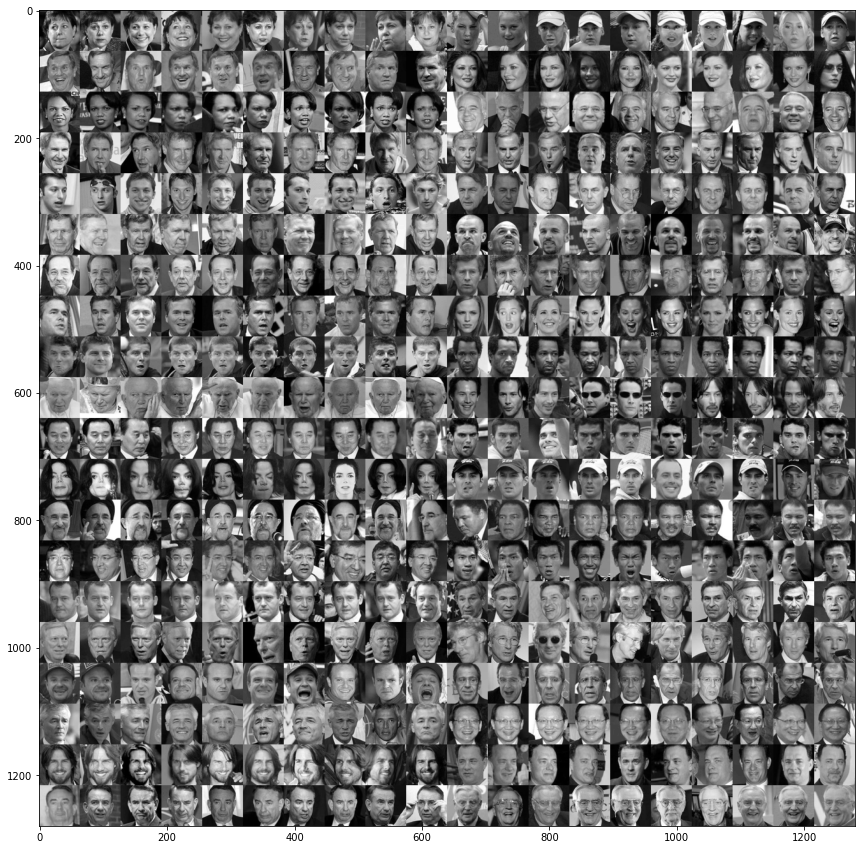

In [197]:
figure(figsize=(15,15))
imshow(toimage(images, 20, 20), cmap='gray')
pass

<span style="color:green;font-size:18px;">**[CODE]**</span> **Fill in the following two functions.**

<span style="color:purple;font-size:18px;">For grading: I tried for an hour or so to make this match Dr. Farrell's answers, but it doesn't seem to be exactly the same at the end classification.  I'm fairly sure that my code to reconstruct is right, so it might be this step that is making my results different.  Not sure though, this step seems to be fine too.</span> 

In [186]:
def split_train_test(images):
    '''Divide the images into a training set and a test set. Half of the
    images for each person go in either set.'''
    train = images[1:][::2]
    test = images[0:][::2]
#     print(len(images), len(train), len(test))
    return train, test
    
def fit_pca(train):
    '''Return a PCA model that has been fit to the training images.'''
    pca = PCA()
    pca.fit(train.reshape(-1, 64*64))
    return pca

<span style="color:green;font-size:18px;">**[TEST]**</span> **Run the following cell.**
<br>This will generate a plot showing how much of the total amount of variance in the data is captured by subset of the eigenfaces. Reference lines are drawn for 80%, 90%, 95% and 99%.

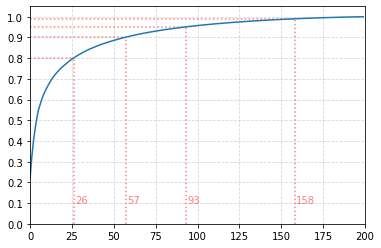

In [187]:
train, test = split_train_test(images)
# labels correspond to a name in the names list
train_label = np.arange(train.shape[0]) // 5
test_label = np.arange(test.shape[0]) // 5

pca = fit_pca(train)

cumulative_var = pca.explained_variance_ratio_.cumsum()
pvals = [.8, .9, .95, .99]
ps = searchsorted(cumulative_var, pvals)
plot(cumulative_var)
hlines(pvals, 0, ps, color='red', linestyle=':',alpha=0.5)
vlines(ps, 0, pvals, color='red', linestyle=':',alpha=0.5)
for v in ps:
    text(v+1, .1, v, color='r', alpha=0.5)
ylim(0,1.05)
xlim(-.05,train.shape[0])
yticks(arange(11)/10)
grid(alpha=0.5, linestyle='--')

<span style="color:green;font-size:18px;">**[CODE]**</span> **Fill in the code to define the mean face and the tiled image of 100 eigenfaces.**

In [188]:
mean_face = pca.mean_.reshape(64, 64)
faces = pca.components_.reshape(-1, 64, 64)[:100, :, :]
eigenface_image = np.zeros((640, 640))
for row_i in range(10):
    for col_j in range(10):
#         print(row_i*64, (row_i*64)+64, col_j*64, (col_j*64)+64)
        eigenface_image[row_i*64:(row_i*64)+64, col_j*64:(col_j*64)+64] = faces[row_i * 10 + col_j]
# print(eigenface_image)

<span style="color:green;font-size:18px;">**[TEST]**</span> **Run the following cell.**

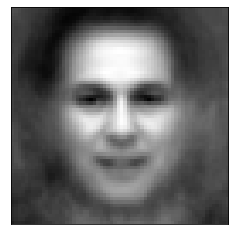

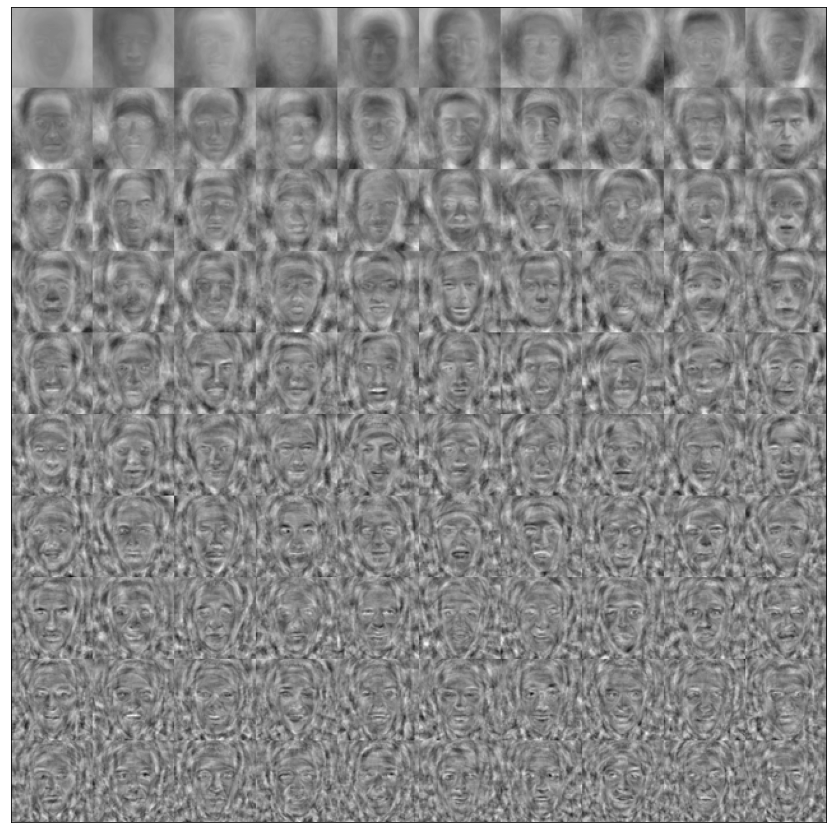

In [189]:
figure()
imshow(mean_face, cmap='gray'); xticks([]); yticks([])
figure(figsize=(15,15))
imshow(eigenface_image, cmap='gray'); xticks([]); yticks([])
pass

<span style="color:green;font-size:18px;">**[CODE]**</span> **Fill in the code for the following two functions.**

In [190]:
def face_space_coordinates(pca, imgs, k=100):
    '''Project the the images in imgs onto the face space and return the
    coordinates. pca is the PCA object. imgs is a Nx64x64 array. The return
    value should be an NxK array, with the K face space coordinates for
    each of the N images.'''
    imgs_centered = imgs.reshape(-1, 64*64) - pca.mean_
#     print(imgs_centered.shape, pca.components_[:k].transpose().shape)
    coords = np.matmul(imgs_centered, pca.components_[:k].transpose())
#     print(coords.shape, coords_legit.shape)
    return coords

def reconstruct(pca, coords):
    '''Reconstruct face images as linear combinations of eigenfaces (plus 
    the mean face), where the weights are the face space coordinates.
    pca is PCA object. coords is an Nx100 array: 100 face space coordinates
    for each of N different images.'''
    recon = np.dot(coords, pca.components_[:coords.shape[-1]]) + pca.mean_
    return recon

<span style="color:green;font-size:18px;">**[TEST]**</span> **Run the following cell.**

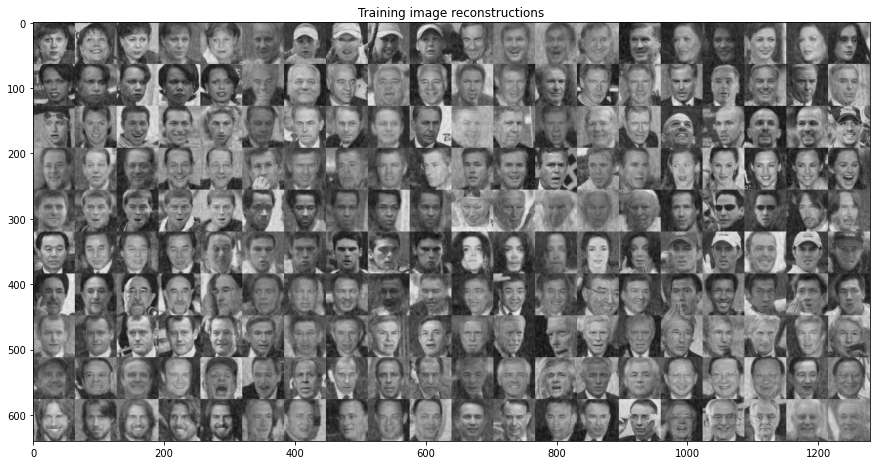

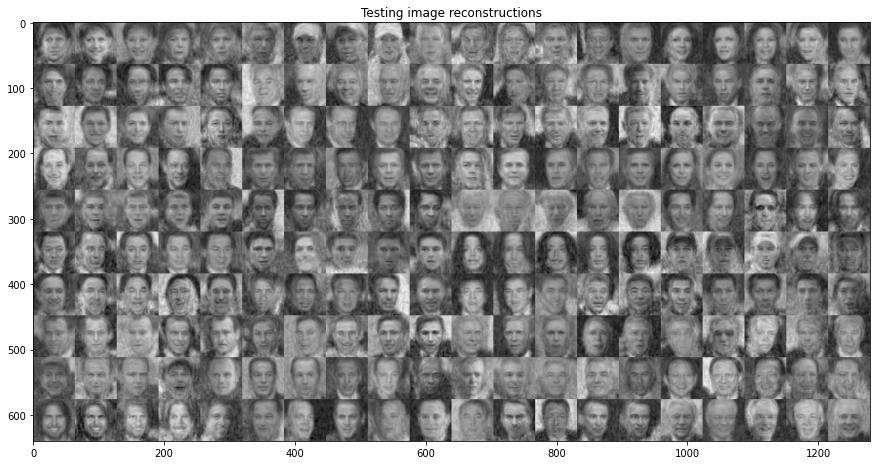

In [191]:
k = 100  # the number of components to use
train_coords = face_space_coordinates(pca, train, k)
test_coords = face_space_coordinates(pca, test, k)

train_recon = reconstruct(pca, train_coords)
test_recon = reconstruct(pca, test_coords)

figure(figsize=(15,15))
imshow(toimage(train_recon, 10, 20), cmap='gray')
title('Training image reconstructions')

figure(figsize=(15,15))
imshow(toimage(test_recon, 10, 20), cmap='gray')
title('Testing image reconstructions')
pass

<span style="color:green;font-size:18px;">**[CODE]**</span> **Fill in the code for the following function.**

In [195]:
def classify_nearest_neighbor(train_coords, test_coords, train_label, test_label):
    '''Classifies each test image according to the label of the nearest
    training image. Nearness is calculated as euclidean distance in face
    space. Use the function cdist to calculate distance. Return overall
    classification accuracy (the percentage of faces that were correctly
    classified) as well as the per-person accuracy (an array of percentages,
    one for each person).'''
    overall_accuracy = []
    pp_acc = [[] for value in set(test_label)]
    Y = cdist(train_coords, test_coords, 'euclidean')
    for col in range(Y.shape[-1]):
        idx_argmin = Y[col].argmin()
        closest_train = train_label[idx_argmin]
#         print(test_label[col], closest_train)
        if test_label[col] == closest_train:
            overall_accuracy.append(1)
            pp_acc[test_label[col]].append(1)
        else:
            overall_accuracy.append(0)
            pp_acc[test_label[col]].append(0)           
            
    
    overall = np.array(overall_accuracy).mean()
    perperson = np.array([np.array(arr).mean() for arr in pp_acc])
    return overall, perperson

<span style="color:green;font-size:18px;">**[TEST]**</span> **Run the following cell.**
<br>This will generate a plot showing the overall accuracy and the accuracy for each person.

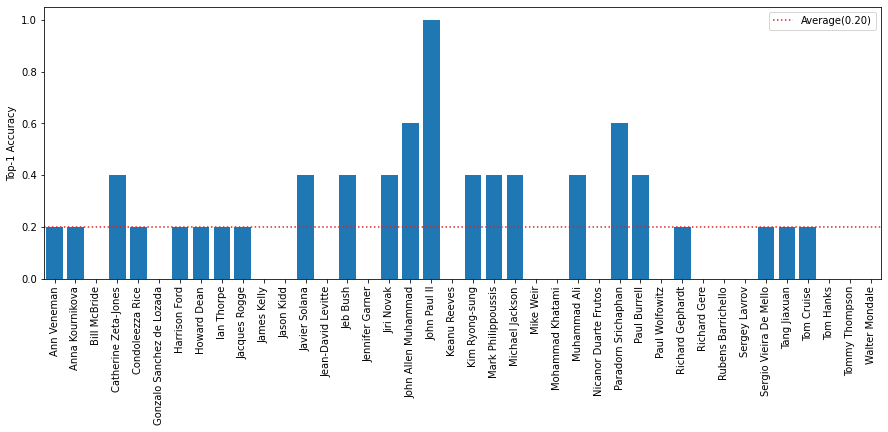

In [196]:
overall, perperson = classify_nearest_neighbor(train_coords, test_coords, train_label, test_label)

figure(figsize=(15,5))
bar(arange(perperson.shape[0]), perperson)
axhline(overall, 0, 1, color='tab:red', linestyle=':', label='Average({:.2f})'.format(overall))
xlim(-0.5, perperson.shape[0]-0.5)
xticks(arange(perperson.shape[0]))
gca().xaxis.set_ticklabels([n.replace('_',' ') for n in names], rotation=90)
ylabel('Top-1 Accuracy')
legend()
pass

<span style="color:green;font-size:18px;">**[WRITE]**</span> **Answer the following questions: Was this a good or bad classifier? What could be some of the problems with it? How might it be improved?**

It's an okay classifier, but definitely not the best. Overall accuracy is still around 20%, which isn't awful considering there's 40 different people, but isn't great either. These people look so different, there should be a better way (like Deep Learning, or a classifier on top of the features that isn't just a nearest neighbor.  My guess would be that because of the different angles and poses of faces, it more easily confuses them with others in the same pose, rather than ones with the same face.  You could improve this by using a more advanced classifier, like boosting or deep learning techniques. Or not using PCA and using the raw images with a neural network or something.

---
## **Final Thoughts**
---

You've come to the end of the exam and the end of the class. Congratulations! I hope that you learned something and had a good experience.

#### **SOLUTION**

- <span style='color:green'>**[5 pts]**</span> Answer the writing prompts.

<span style="color:green;font-size:18px;">**[WRITE]**</span> **Answer the following:**
- Please rate the difficulty of the final as easy, medium, or hard, and explain what, if anything, was challenging about it.
- Explain what you thought was the most impactful part of the class for you.

I thought this final was medium. I'd say that because there were still things I didn't know that I had to figure out how to implement and it wasn't trivial.  However, the things we had to figure out how to learn weren't too hard, so it was oddly satisifying.  I think these were good problems for a final, and fun to do!

The most impactful part of the class for me was when we went over the basic image features and were able to see the evolution of the CV field from older techniques to more modern.  I felt like that really gave me a good overview and combined with the labs, helped me learn a lot.  Since I hadn't taken 355, the early portion of the class was difficult, but I felt it really helped me grow and understand things. So thank you for the great course!

**END FINAL EXAM**